In [ ]:
import kagglehub

path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
print("Path to dataset files:", path)

100%|██████████| 199M/199M [00:01<00:00, 203MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2


In [ ]:
# Point to the subfolder that has the class subfolders (Benign, Malignant, Normal)
import os
dataset_path = os.path.join(path, "The IQ-OTHNCCD lung cancer dataset",
    "The IQ-OTHNCCD lung cancer dataset")

In [ ]:
print(os.listdir(dataset_path))


['Normal cases', 'IQ-OTH_NCCD lung cancer dataset.txt', 'Malignant cases', 'Bengin cases']


In [ ]:

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:
DATA_DIR = dataset_path # Replace with your actual dataset path
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Load the full dataset with ImageFolder
full_dataset = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform)

# Get the labels for stratification
y = [label for _, label in full_dataset.samples]
print("Total images:", len(full_dataset))


Total images: 1097


In [ ]:
# First, split into train (70%) and temp (30%)
train_idx, temp_idx, y_train, y_temp = train_test_split(
    np.arange(len(full_dataset)), y,
    test_size=0.30, stratify=y, random_state=SEED
)

# Now, split temp into validation and test
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp,
    test_size=0.60, stratify=y_temp, random_state=SEED
)

# Create Subset datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


Train size: 767
Validation size: 132
Test size: 198


In [ ]:
# --- Calculate weights for the training subset ---
train_labels = [full_dataset.samples[i][1] for i in train_idx]
class_counts_train = {}
for label in train_labels:
    class_counts_train[label] = class_counts_train.get(label, 0) + 1

print("Training class counts:", class_counts_train)

weights = [1.0 / class_counts_train[full_dataset.samples[i][1]] for i in train_idx]
weights = torch.DoubleTensor(weights)

from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Training class counts: {0: 84, 1: 392, 2: 291}


In [ ]:

# Extract class names (from the original dataset)
class_names = full_dataset.classes
print("Class names:", class_names)


Class names: ['Bengin cases', 'Malignant cases', 'Normal cases']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # For 3 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 15


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Validation Accuracy: {val_acc:.2f}\n")


Epoch [1/15] - Training Loss: 0.5398
Epoch [1/15] - Validation Accuracy: 0.86

Epoch [2/15] - Training Loss: 0.2865
Epoch [2/15] - Validation Accuracy: 0.55

Epoch [3/15] - Training Loss: 0.2656
Epoch [3/15] - Validation Accuracy: 0.95

Epoch [4/15] - Training Loss: 0.2647
Epoch [4/15] - Validation Accuracy: 0.78

Epoch [5/15] - Training Loss: 0.2568
Epoch [5/15] - Validation Accuracy: 0.81

Epoch [6/15] - Training Loss: 0.1125
Epoch [6/15] - Validation Accuracy: 0.82

Epoch [7/15] - Training Loss: 0.1060
Epoch [7/15] - Validation Accuracy: 0.60

Epoch [8/15] - Training Loss: 0.0567
Epoch [8/15] - Validation Accuracy: 0.96

Epoch [9/15] - Training Loss: 0.0448
Epoch [9/15] - Validation Accuracy: 0.71

Epoch [10/15] - Training Loss: 0.1830
Epoch [10/15] - Validation Accuracy: 0.89

Epoch [11/15] - Training Loss: 0.0534
Epoch [11/15] - Validation Accuracy: 0.95

Epoch [12/15] - Training Loss: 0.1104
Epoch [12/15] - Validation Accuracy: 0.88

Epoch [13/15] - Training Loss: 0.0837
Epoch [1

In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test F1-score: {test_f1:.2f}")

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


Test Accuracy: 0.98
Test F1-score: 0.97
Confusion Matrix:
[[ 20   0   2]
 [  0 101   0]
 [  1   0  74]]


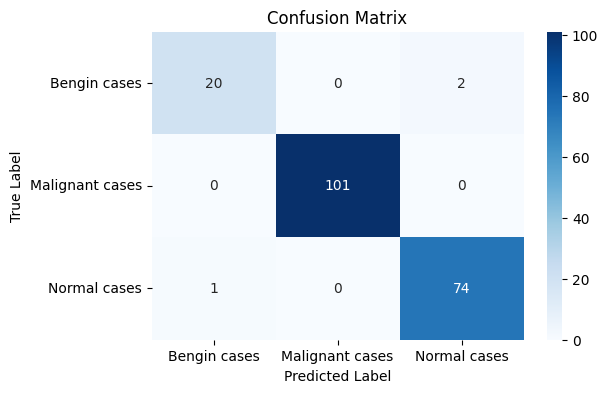

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
class_names = test_dataset.dataset.classes  #  ["Benign cases", "Malignant cases", "Normal cases"]

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:

                 precision    recall  f1-score   support

   Bengin cases       0.95      0.91      0.93        22
Malignant cases       1.00      1.00      1.00       101
   Normal cases       0.97      0.99      0.98        75

       accuracy                           0.98       198
      macro avg       0.98      0.97      0.97       198
   weighted avg       0.98      0.98      0.98       198



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



=== Classifying images in: bengin ===
bengin_1.png -> Predicted as: Normal cases


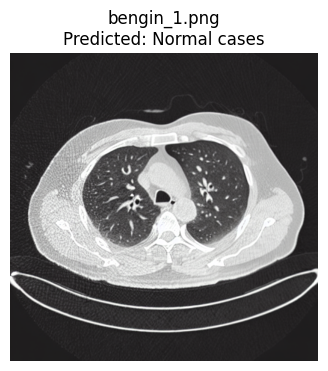

bengin_2.png -> Predicted as: Normal cases


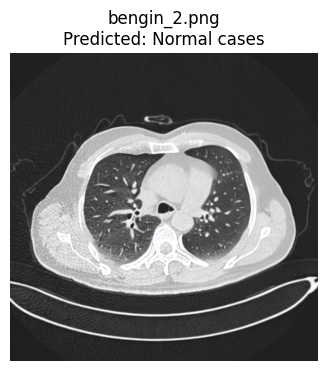

bengin_3.png -> Predicted as: Bengin cases


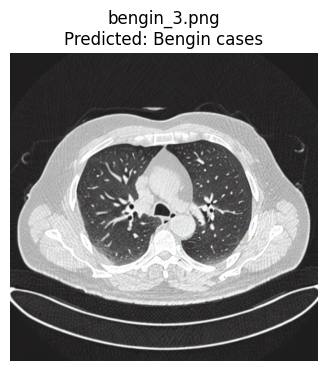

bengin_4.png -> Predicted as: Bengin cases


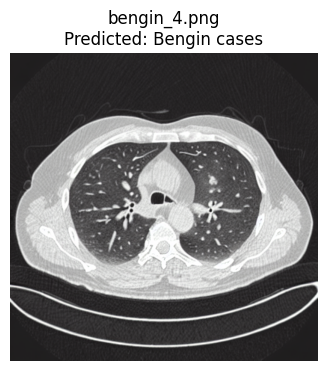

bengin_5.png -> Predicted as: Normal cases


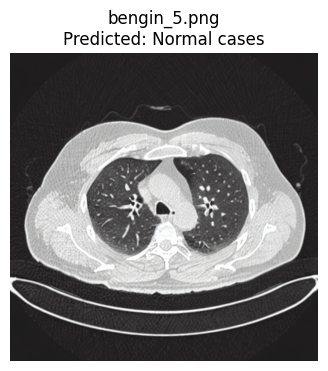

bengin_6.png -> Predicted as: Normal cases


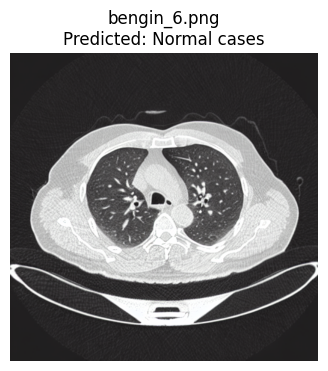

bengin_7.png -> Predicted as: Bengin cases


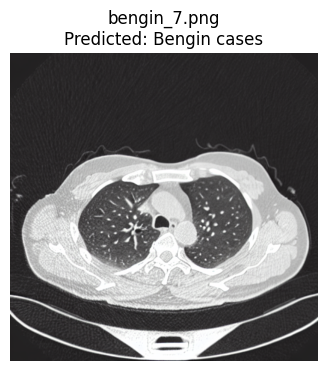

bengin_8.png -> Predicted as: Malignant cases


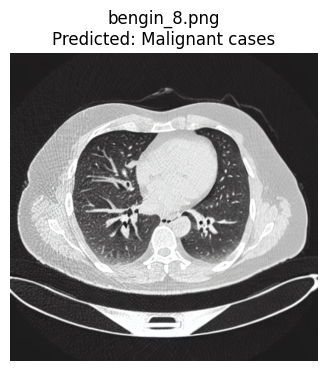

bengin_9.png -> Predicted as: Normal cases


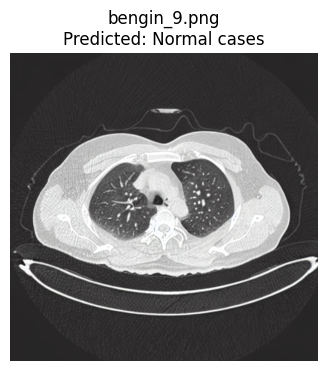

bengin_10.png -> Predicted as: Normal cases


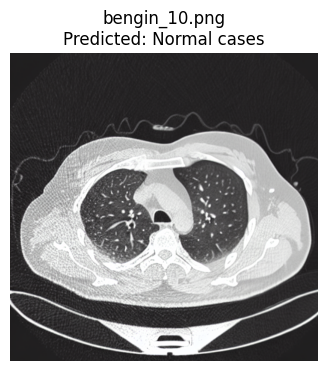


=== Classifying images in: healthy ===
healthy_1.png -> Predicted as: Normal cases


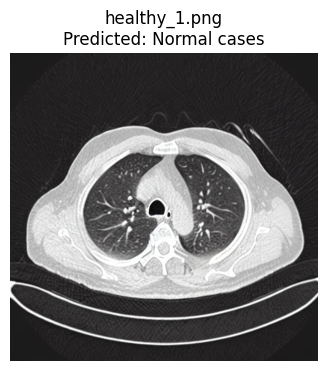

healthy_2.png -> Predicted as: Normal cases


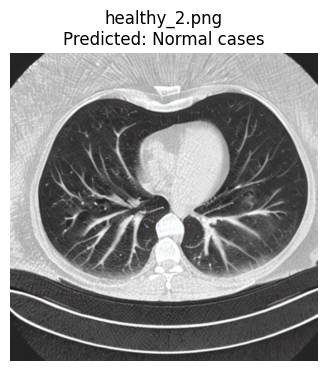

healthy_3.png -> Predicted as: Normal cases


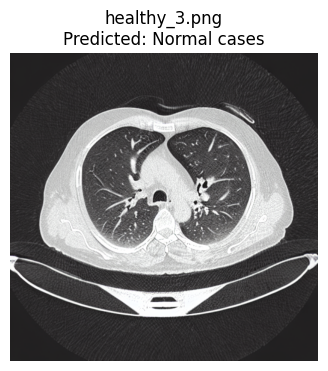

healthy_4.png -> Predicted as: Normal cases


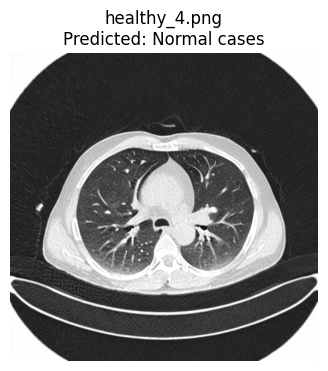

healthy_5.png -> Predicted as: Normal cases


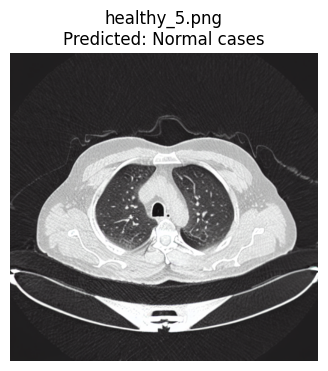

healthy_6.png -> Predicted as: Malignant cases


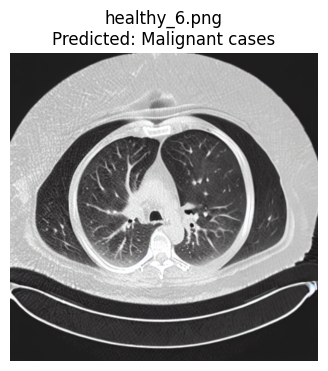

healthy_7.png -> Predicted as: Bengin cases


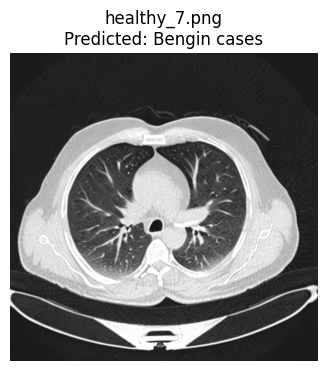

healthy_8.png -> Predicted as: Normal cases


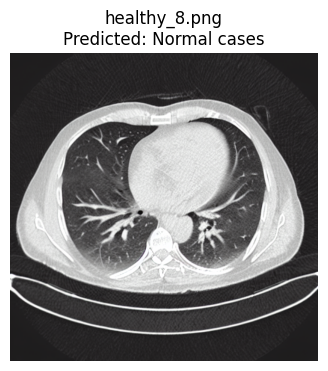

healthy_9.png -> Predicted as: Bengin cases


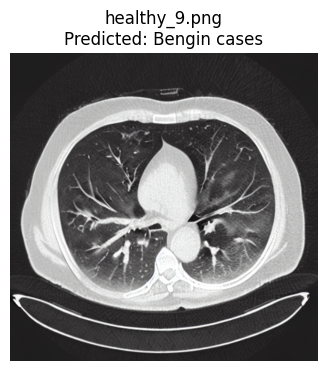

healthy_10.png -> Predicted as: Malignant cases


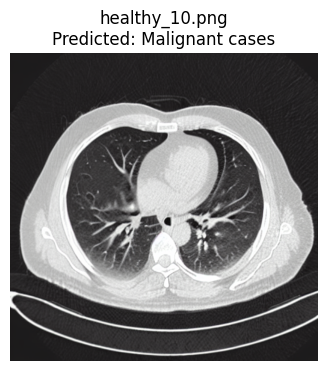


=== Classifying images in: malignant ===
malignant_1.png -> Predicted as: Malignant cases


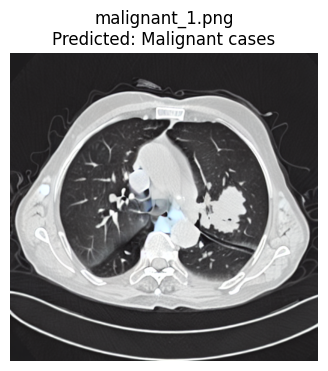

malignant_2.png -> Predicted as: Malignant cases


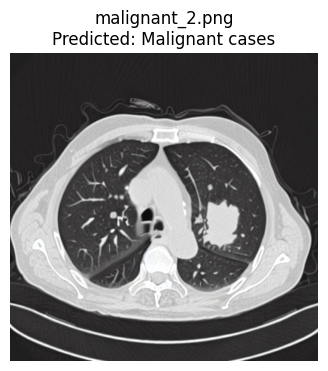

malignant_3.png -> Predicted as: Malignant cases


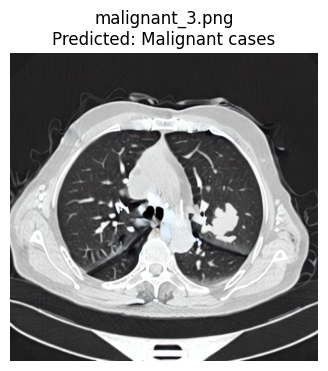

malignant_4.png -> Predicted as: Malignant cases


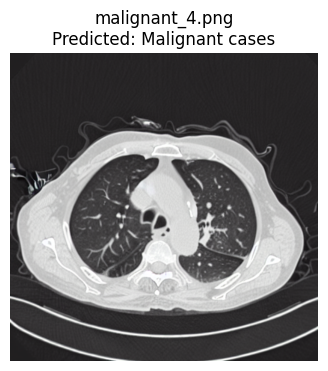

malignant_5.png -> Predicted as: Malignant cases


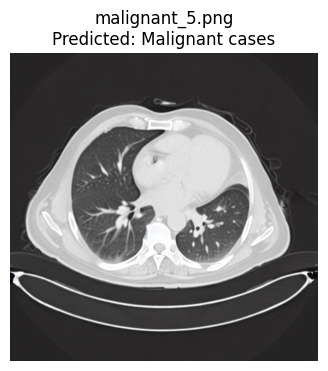

malignant_6.png -> Predicted as: Malignant cases


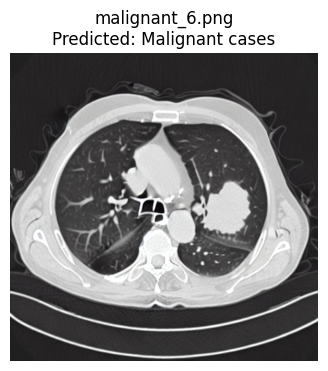

malignant_7.png -> Predicted as: Malignant cases


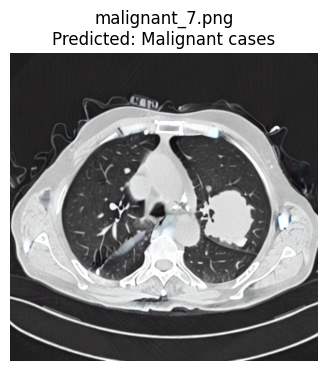

malignant_8.png -> Predicted as: Malignant cases


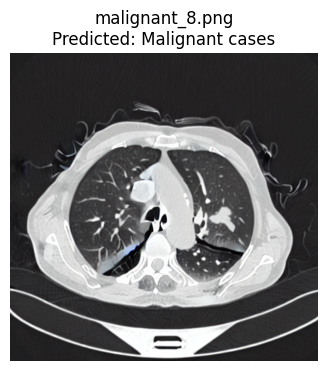

malignant_9.png -> Predicted as: Malignant cases


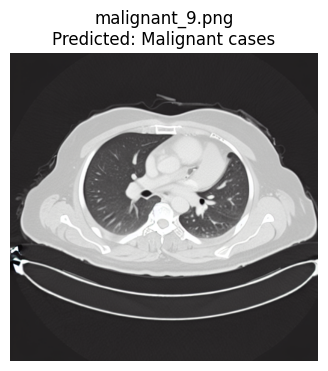

malignant_10.png -> Predicted as: Malignant cases


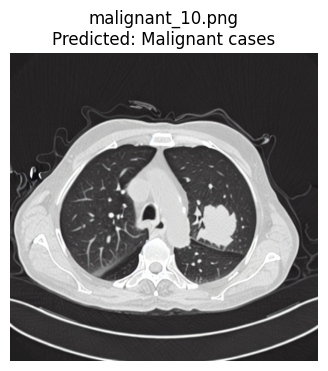

In [ ]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  # For displaying images

# 1. Use the same transforms as in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# 2. Point to generated_images folder on Google Drive
root_dir = "/content/drive/MyDrive/generated_images"

# 3. Ensure your model is loaded and set to eval mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ["Benign cases", "Malignant cases", "Normal cases"]

# 4. Loop over each folder
for folder_label in ["bengin", "healthy", "malignant"]:
    folder_path = os.path.join(root_dir, folder_label)
    print(f"\n=== Classifying images in: {folder_label} ===")

    for filename in os.listdir(folder_path):
        # Only process image files
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(folder_path, filename)

            # Load the image using PIL
            image = Image.open(image_path).convert("RGB")

            # Apply the transform
            input_tensor = transform(image).unsqueeze(0).to(device)

            # Inference: get model output and predicted class
            with torch.no_grad():
                outputs = model(input_tensor)
                _, predicted_idx = torch.max(outputs, 1)
            predicted_class = class_names[predicted_idx.item()]
            print(f"{filename} -> Predicted as: {predicted_class}")

            # Display the image with the predicted label
            plt.figure(figsize=(4,4))
            plt.imshow(image)
            plt.title(f"{filename}\nPredicted: {predicted_class}")
            plt.axis("off")
            plt.show()





In [ ]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import gradio as gr


model.eval()




# 4. Define a function that takes in an image and returns the prediction string.
def classify_lung_image(img):
    # Convert PIL image to the required tensor
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, predicted_idx = torch.max(outputs, 1)
    predicted_class = class_names[predicted_idx.item()]
    return f"Prediction: {predicted_class}"

# 5. Create a Gradio interface
demo = gr.Interface(
    fn=classify_lung_image,            # the function to call
    inputs=gr.Image(type="pil"),       # user uploads an image (PIL format)
    outputs="text",                    # display text output
    title="Lung CT Classification",
    description="Upload a lung CT image (Benign, Malignant, or Normal) and see the model's prediction."
)

# 6. Launch the app
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6708343b0d1621c0a7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
torch.save(model.state_dict(), 'model.pth')
from google.colab import files
files.download("model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>